In [76]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import sklearn

from sklearn.linear_model import LinearRegression

# Part I

In [77]:
# Import the data
tree = pd.read_csv('tree.csv')
tree

tree['t'] = tree['t'].replace(to_replace=0, value=0.0001)


vert_genes = pd.read_csv('vert_genes.csv')
tree

,Parent,Child,age_ch,t,species
0,222.0,1,0.000000,9.000250,Peromyscus_maniculatus
1,222.0,2,0.000000,9.000250,Mus_musculus
2,221.0,3,0.000000,12.172706,Cricetulus_griseus
3,220.0,4,0.000000,14.684269,Rattus_norvegicus
4,219.0,5,0.000000,17.062881,Mesocricetus_auratus
...,...,...,...,...,...
402,399.0,403,7.861905,1.640772,NaN
403,403.0,404,5.750020,2.111885,NaN
404,404.0,405,5.500000,0.250020,NaN
405,403.0,406,5.000000,2.861905,NaN


In [78]:
sigma_sq = 2500

# Create a directed graph

def create_graph(tree, alpha = 0.4, beta = 1, sigma_sq = 2500):
    G = nx.DiGraph()
    for _, row in tree.iterrows():
        if not pd.isna(row['Parent']):
            G.add_edge(int(row["Parent"]), int(row["Child"]), time = row["t"], a = alpha*row["t"], b = beta, variance = sigma_sq*row["t"])
            
    return G

G = create_graph(tree)

# # Get the 'b' attribute for a single edge (for example, edge (1, 2))
# b_single_edge = G[222][1]['b']

# print(b_single_edge)

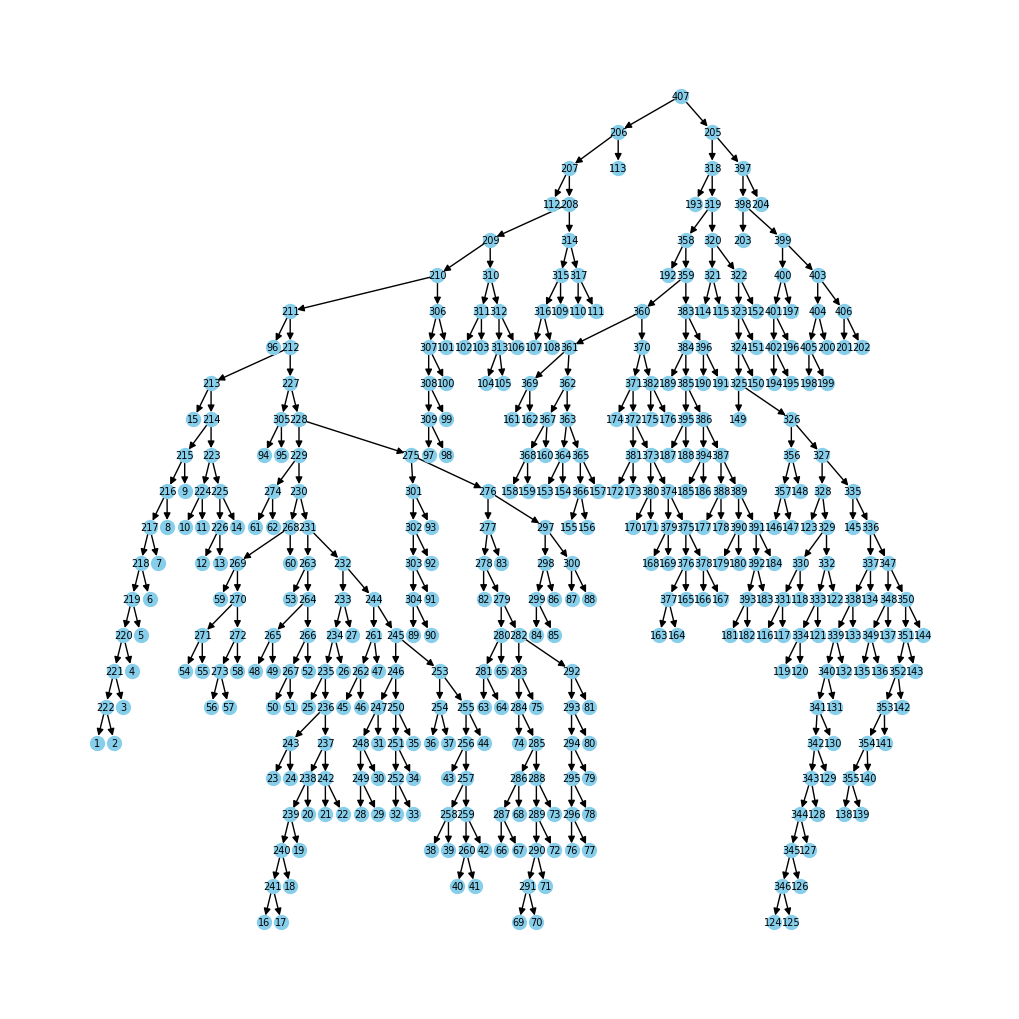

In [79]:
# Plot the graph as a top-down tree
plt.figure(figsize=(10, 10))
pos = nx.nx_agraph.graphviz_layout(G, prog="dot")
nx.draw(G, pos, with_labels=True, font_size = 7, node_color = "Skyblue", node_size = 100)
plt.show()

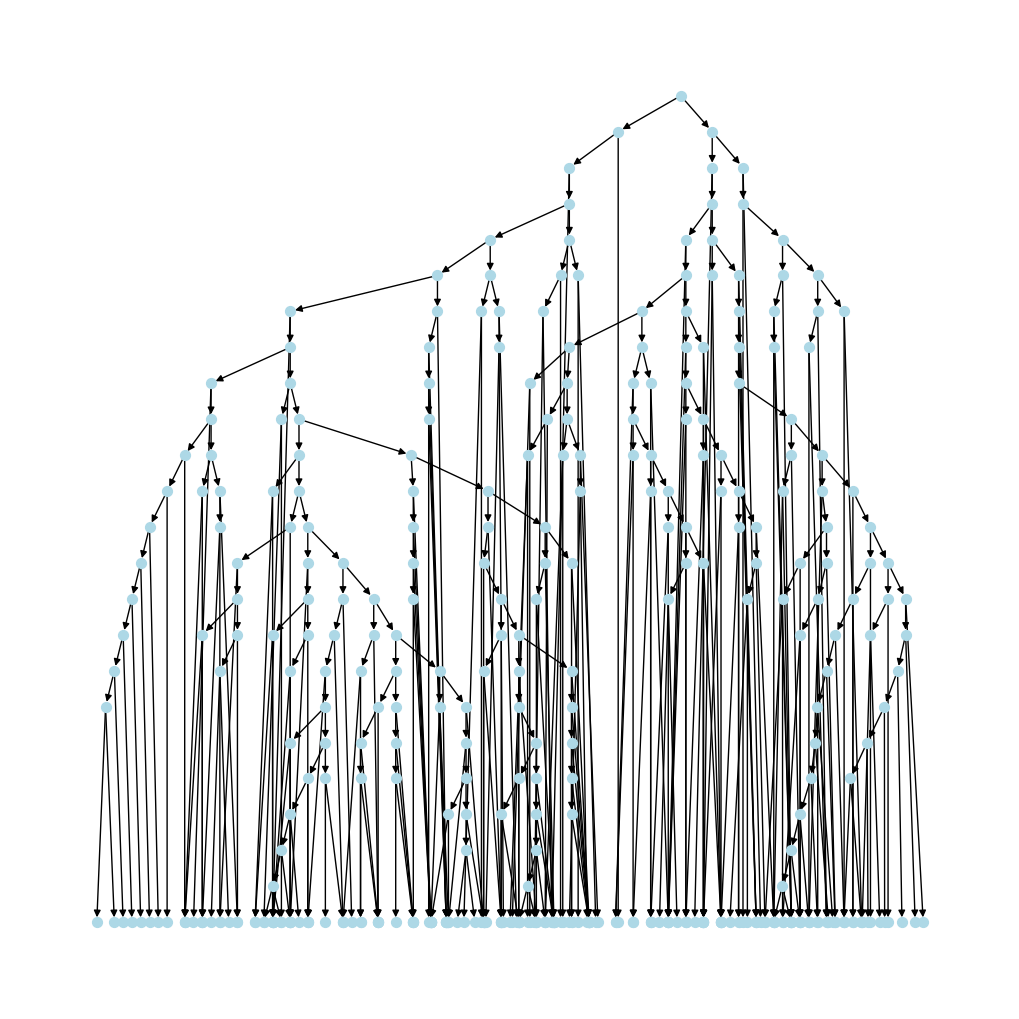

In [80]:
# Get initial layout
pos = nx.nx_agraph.graphviz_layout(G, prog="dot")


nodes = list(G.nodes)

# Find leaf nodes (nodes with no outgoing edges)
leaves = [node for node in nodes if G.out_degree(node) == 0]

# Find minimum depth of the tree
min_depth = min(pos[node][1] for node in pos)  # Highest Y value

# Adjust leaf positions to be at min_depth
for leaf in leaves:
    pos[leaf] = (pos[leaf][0], min_depth)

# Draw the graph
plt.figure(figsize=(10, 10))
nx.draw(G, pos, with_labels=False, node_size=50, node_color="lightblue", edge_color="black")
plt.show()

In [81]:
# Parameters
alpha_0 = 50000
alpha = 0.5
sigma_0_sq = 5000
sigma_sq = 2500
beta = 1

# Simulate length of root node
root = 407

# Function to simulate the length of a node
def simulate_node_length(parent, simulated_lengths):
    for child in G.successors(parent):
        t = G[parent][child]['time']
        mean = alpha * t + beta * simulated_lengths[parent]
        std = np.sqrt(sigma_sq * t)
        simulated_lengths[child] = np.random.normal(mean, std)
        simulate_node_length(child, simulated_lengths)
    
    return simulated_lengths

In [82]:
n = 1000

def simulate_data(n):
    

    X_values = []
    Y_values = []

    leaf_nodes = [node for node in G.nodes if G.out_degree(node) == 0]

    for i in range(n):
        simulated_lengths = {}
        simulated_lengths[root] = np.random.normal(alpha_0, np.sqrt(sigma_0_sq))
        simulated_lengths = simulate_node_length(root, simulated_lengths)

        simulated_x = [simulated_lengths[node] for node in leaf_nodes]
        X_values.append(simulated_x)
        Y_values.append(simulated_lengths[root])

    return(np.array(X_values), np.array(Y_values))

X_values, Y_values = simulate_data(n)

print(X_values.shape)
print(Y_values.shape)

(1000, 204)
(1000,)


In [83]:
print(Y_values[0])

50017.45930412778


In [84]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [85]:
model = LinearRegression()

X_train, X_test, Y_train, Y_test = train_test_split(X_values, Y_values, test_size = 0.2)
model.fit(X_train, Y_train)

slope = model.coef_
intercept = model.intercept_

# print(slope)
# print(intercept)

Y_pred = model.predict(X_test)

mae = mean_absolute_error(Y_test, Y_pred)
mse = mean_squared_error(Y_test, Y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(Y_test, Y_pred)

print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"R^2: {r2}")


Mean Absolute Error: 58.60903556192297
Mean Squared Error: 5375.992718080544
Root Mean Squared Error: 73.32116146161724
R^2: -0.090830512511199


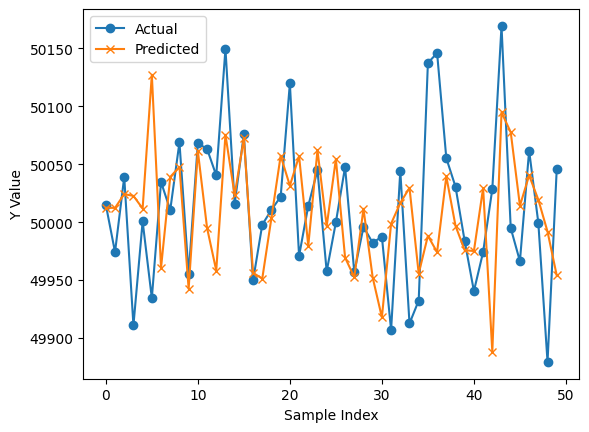

In [86]:
points = 50

plt.plot(Y_test[:points], label="Actual", marker='o')  # First 100 values
plt.plot(Y_pred[:points], label="Predicted", marker='x')
plt.xlabel("Sample Index")
plt.ylabel("Y Value")
plt.legend()
plt.show()

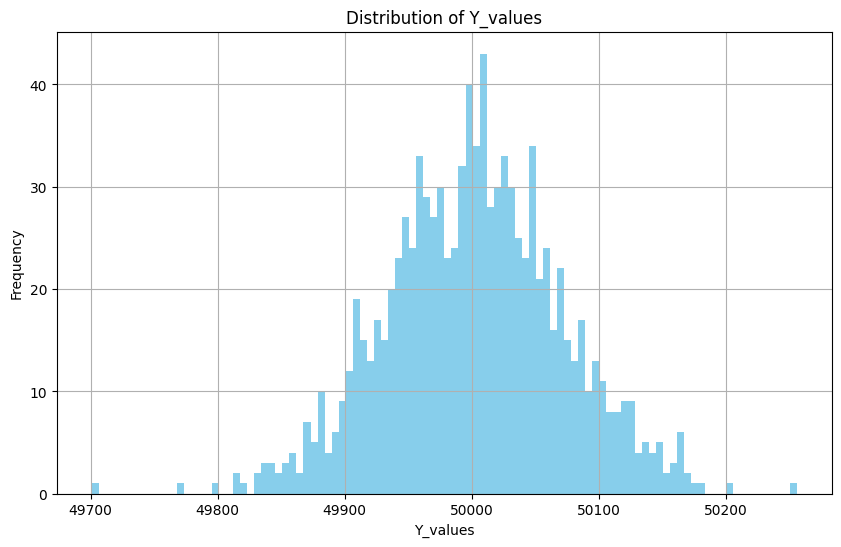

In [87]:
plt.figure(figsize=(10, 6))
plt.hist(Y_values, bins=100, color='skyblue')
plt.title('Distribution of Y_values')
plt.xlabel('Y_values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


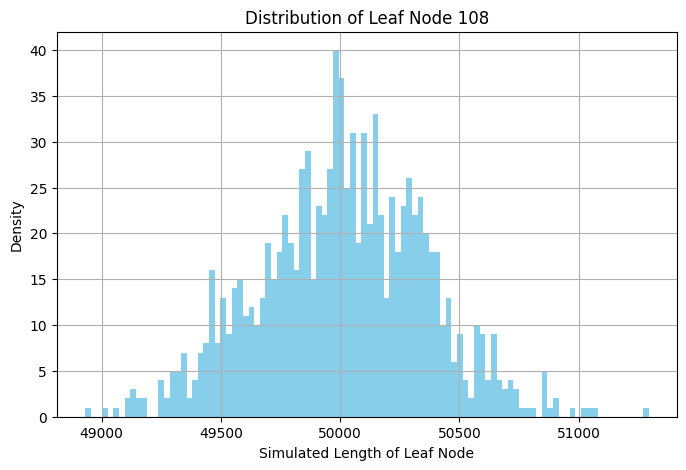

In [88]:
leaf_index = np.random.randint(0,203)  # Choose the index of the leaf node you want to analyze
leaf_data = X_values[:, leaf_index]  # Extract the column for this leaf

# Plot histogram
plt.figure(figsize=(8, 5))
plt.hist(leaf_data, bins=100, color='skyblue')

# Add labels
plt.xlabel("Simulated Length of Leaf Node")
plt.ylabel("Density")
plt.grid(True)
plt.title(f"Distribution of Leaf Node {leaf_index}")

plt.show()

# Part II

In [89]:
def compute_pair_cliques(graph):
    C = nx.Graph()

    for edge in graph.edges:
        C.add_node(edge)

    return C

clique_tree = compute_pair_cliques(G)

print(clique_tree.number_of_nodes())

406


In [90]:
all_parents = tree["Parent"].unique()

# Find the leaf nodes (parents that do not appear in the 'Child' column)
leaf_nodes = [parent for parent in all_parents if parent not in tree["Child"].values]

In [91]:
def get_first_n_nodes(G, root, n):
    nodes = [root]
    current_level = [root]
    while len(nodes) < n:
        next_level = []
        for node in current_level:
            children = list(G.successors(node))
            next_level.extend(children)
            nodes.extend(children)
            if len(nodes) >= n:
                subgraph = G.subgraph(nodes[:n])
                mapping = {old_label: new_label for new_label, old_label in enumerate(subgraph.nodes())}
                return nx.relabel_nodes(subgraph, mapping)
        current_level = next_level
    subgraph = G.subgraph(nodes[:n])
    mapping = {old_label: new_label for new_label, old_label in enumerate(subgraph.nodes())}
    return nx.relabel_nodes(subgraph, mapping)

In [92]:
import numpy as np

def compute_gamma(G):
    # Initialize gamma as an identity matrix
    gamma = np.eye(len(G.nodes))

    # Iterate through the nodes
    for node in G.nodes:
        # Get the parent of the node (if exists)
        parent = next(G.predecessors(node), None)
        if parent is None:
            print(f"Node {node} is the root node")
            continue
        
        # Access the edge attribute 'b' for the edge from 'parent' to 'node'
        b = G[parent][node]['b']  # Access the edge (parent -> node) to get 'b'

        gamma[parent-1, node-1] = -b

    return gamma

gamma = compute_gamma(G)

gamma

Node 407 is the root node


array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [ ]:
def compute_beta():
    beta = np.zeros((len(G.nodes), 1))
    for node in G.nodes:
        parent = next(G.predecessors(node), None)
        if parent is None:
            continue
        a = G[parent][node]['a']
        beta[node-1] = G[parent][node]['a']
        
    return beta

def compute_sigma(G):
    sigma = np.zeros((len(G.nodes)))
    for node in G.nodes:
        parent = next(G.predecessors(node), None)
        if parent is None:
            # Assign the default value for the root node
            sigma[node - 1] = sigma_0_sq
        else:
            # Access the edge attribute 'variance' only if parent exists
            variance = G[parent][node]['variance']
            sigma[node - 1] = variance
    return sigma

beta = compute_beta()
sigma = compute_sigma(G)


J2 = gamma / sigma

J2

import numpy as np

def compute_J(gamma, sigma):
    # Initialize the sum matrix
    J = np.zeros_like(gamma)
    
    # Iterate over each row in gamma
    for i in range(len(gamma)):
        # Get the i-th row (gamma_i) and the corresponding sigma_i
        gamma_i = gamma[i, :]
        sigma_i = sigma[i]
        
        # Compute the outer product of gamma_i with itself, scaled by 1/sigma_i^2 
        outer_product = np.outer(gamma_i, gamma_i) / (sigma_i) # MAYBE USE SIGMA_I^2
        
        # Add the outer product to the sum matrix
        J += outer_product
    
    return J

# Example usage:
J = compute_J(gamma, sigma)


In [ ]:
# # This J is equal to the J computed in the previous cell

# J = np.sum([np.outer(gamma[i], gamma[i]) / (sigma[i])**2 for i in range(len(G))], axis=0)

# J

array([[1.78726937e-08, 1.58974948e-08, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.58974948e-08, 1.78726937e-08, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 2.64446310e-08, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        2.59546442e-06, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 7.89672911e-08, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 4.00000000e-08]])

In [101]:
# Computing h
h = np.sum([(beta[i] / sigma[i]) * gamma[i] for i in range(len(G))], axis=0)

h

array([-2.71050543e-20, -2.71050543e-20,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -2.71050543e-20,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -2.71050543e-20,
        0.00000000e+00,  0.00000000e+00,  2.71050543e-20,  2.71050543e-20,
        0.00000000e+00,  0.00000000e+00, -2.71050543e-20,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  2.71050543e-20,
        2.71050543e-20,  0.00000000e+00,  2.71050543e-20,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  

In [ ]:
import numpy as np
import networkx as nx

def message_passing(G, max_iter=100, tol=1e-6):
    # Initialize messages
    messages_J = {}  # Dictionary to store J_i!j (precision matrices)
    messages_h = {}  # Dictionary to store h_i!j (mean terms)
    
    # Initialize messages to zero or identity matrices
    for (i, j) in G.edges:
        messages_J[(i, j)] = np.eye(1)  # Identity matrix for J_i!j (1x1 since scalar)
        messages_h[(i, j)] = np.zeros(1)  # Zero vector for h_i!j (1x1)
    
    # Initialize node potentials
    node_potentials = {}  # Store potential for each node
    for node in G.nodes:
        node_potentials[node] = {'J': np.eye(1), 'h': np.zeros(1)}  # Default is identity matrix and zero vector
    
    # Start message passing
    for iteration in range(max_iter):
        prev_messages_J = messages_J.copy()
        prev_messages_h = messages_h.copy()
        
        # Update messages for each node
        for i in G.nodes:
            # Aggregate messages from neighbors
            J_inj = node_potentials[i]['J']  # Start with node's local precision
            h_inj = node_potentials[i]['h']  # Start with node's local mean
            
            # Aggregate incoming messages from neighbors
            for neighbor in G.neighbors(i):
                if neighbor == i:
                    continue
                J_inj += messages_J.get((neighbor, i), np.eye(1))
                h_inj += messages_h.get((neighbor, i), np.zeros(1))
            
            # Compute the message from i to each neighbor
            for neighbor in G.neighbors(i):
                if neighbor == i:
                    continue
                
                J_ij = -messages_J.get((neighbor, i), np.eye(1)) @ np.linalg.inv(J_inj) @ messages_J.get((neighbor, i), np.eye(1))
                h_ij = -messages_J.get((neighbor, i), np.eye(1)) @ np.linalg.inv(J_inj) @ h_inj
                
                # Store the updated messages
                messages_J[(i, neighbor)] = J_ij
                messages_h[(i, neighbor)] = h_ij
        
        # Check for convergence
        message_change = sum(np.linalg.norm(messages_J[(i, j)] - prev_messages_J.get((i, j), np.eye(1))) for (i, j) in G.edges)
        if message_change < tol:
            print(f"Converged after {iteration+1} iterations.")
            break
    
    # Reconstruct mean and covariance for each node
    node_means = {}
    node_covariances = {}
    for i in G.nodes:
        # Compute the total precision and mean for node i
        J_total = node_potentials[i]['J']
        h_total = node_potentials[i]['h']
        
        # Aggregate messages from neighbors
        for neighbor in G.neighbors(i):
            J_total += messages_J.get((neighbor, i), np.eye(1))
            h_total += messages_h.get((neighbor, i), np.zeros(1))
        
        # Compute the mean and covariance for node i
        node_means[i] = np.linalg.inv(J_total) @ h_total
        node_covariances[i] = np.linalg.inv(J_total)
    
    return node_means, node_covariances, messages_J, messages_h

node_means, node_covariances, messages_J, messages_h = message_passing(G)
print("Node Means:", node_means)
print("Node Covariances:", node_covariances)


Node Means: {222: array([0.]), 1: array([0.]), 2: array([0.]), 221: array([0.]), 3: array([0.]), 220: array([0.]), 4: array([0.]), 219: array([0.]), 5: array([0.]), 218: array([0.]), 6: array([0.]), 217: array([0.]), 7: array([0.]), 216: array([0.]), 8: array([0.]), 215: array([0.]), 9: array([0.]), 224: array([0.]), 10: array([0.]), 11: array([0.]), 226: array([0.]), 12: array([0.]), 13: array([0.]), 225: array([0.]), 14: array([0.]), 213: array([0.]), 15: array([0.]), 241: array([0.]), 16: array([0.]), 17: array([0.]), 240: array([0.]), 18: array([0.]), 239: array([0.]), 19: array([0.]), 238: array([0.]), 20: array([0.]), 242: array([0.]), 21: array([0.]), 22: array([0.]), 243: array([0.]), 23: array([0.]), 24: array([0.]), 235: array([0.]), 25: array([0.]), 234: array([0.]), 26: array([0.]), 233: array([0.]), 27: array([0.]), 249: array([0.]), 28: array([0.]), 29: array([0.]), 248: array([0.]), 30: array([0.]), 247: array([0.]), 31: array([0.]), 252: array([0.]), 32: array([0.]), 33

In [106]:
import numpy as np
import networkx as nx
import pandas as pd

# Define sigma_0_sq for the root node's variance (ensure it's defined)
sigma_0_sq = 2500

# Create a directed graph
def create_graph(tree, alpha=0.4, beta=1, sigma_sq=2500):
    G = nx.DiGraph()
    for _, row in tree.iterrows():
        if not pd.isna(row['Parent']):
            G.add_edge(int(row["Parent"]), int(row["Child"]), 
                       time=row["t"], a=alpha*row["t"], b=beta, variance=sigma_sq*row["t"])
    return G

# Helper function to get the first n nodes
def get_first_n_nodes(G, root, n):
    nodes = [root]
    current_level = [root]
    while len(nodes) < n:
        next_level = []
        for node in current_level:
            children = list(G.successors(node))
            next_level.extend(children)
            nodes.extend(children)
            if len(nodes) >= n:
                subgraph = G.subgraph(nodes[:n])
                mapping = {old_label: new_label for new_label, old_label in enumerate(subgraph.nodes())}
                return nx.relabel_nodes(subgraph, mapping)
        current_level = next_level
    subgraph = G.subgraph(nodes[:n])
    mapping = {old_label: new_label for new_label, old_label in enumerate(subgraph.nodes())}
    return nx.relabel_nodes(subgraph, mapping)

# Compute gamma matrix
def compute_gamma(G):
    gamma = np.eye(len(G.nodes))  # Initialize gamma as identity matrix
    for node in G.nodes:
        parent = next(G.predecessors(node), None)
        if parent is None:
            continue
        b = G[parent][node]['b']  # Get the edge attribute 'b'
        gamma[parent-1, node-1] = -b  # Assign to gamma (adjust for 0-based indexing)
    return gamma

# Compute beta vector
def compute_beta(G):
    beta = np.zeros((len(G.nodes), 1))
    for node in G.nodes:
        parent = next(G.predecessors(node), None)
        if parent is None:
            continue
        a = G[parent][node]['a']
        beta[node-1] = a  # Assign 'a' value to beta (adjust for 0-based indexing)
    return beta

# Compute sigma (variance) vector
def compute_sigma(G):
    sigma = np.zeros(len(G.nodes))
    for node in G.nodes:
        parent = next(G.predecessors(node), None)
        if parent is None:
            sigma[node - 1] = sigma_0_sq  # Root node variance (sigma_0_sq)
        else:
            variance = G[parent][node]['variance']
            sigma[node - 1] = variance  # Child node variance
    return sigma

# Compute J matrix
def compute_J(gamma, sigma):
    J = np.zeros_like(gamma)
    for i in range(len(gamma)):
        gamma_i = gamma[i, :]
        sigma_i = sigma[i]
        
        # Ensure no zero variance (avoid division by zero)
        if sigma_i == 0:
            continue
        
        # Compute outer product of gamma_i with itself, scaled by 1/sigma_i^2
        outer_product = np.outer(gamma_i, gamma_i) / (sigma_i ** 2)
        J += outer_product
    
    return J

# Message passing function for one iteration (propagate messages)
def message_passing_step(J, h, G):
    # Create a copy of J and h to store the new values
    new_J = np.copy(J)
    new_h = np.copy(h)

    for node in G.nodes:
        parent = next(G.predecessors(node), None)

        if parent is None:
            continue
        
        # Get the necessary attributes for the parent-child relationship
        b = G[parent][node]['b']
        sigma_parent = sigma[parent - 1]  # Parent node's variance
        sigma_node = sigma[node - 1]  # Current node's variance
        
        # Update J and h based on the message passing rules        
        new_J[node-1, parent-1] = -b / sigma_parent
        new_h[node-1] = h[node-1] - (J[node-1, parent-1] * h[parent-1])
    
    return new_J, new_h

# Import the data
tree = pd.read_csv('tree.csv')
tree['t'] = tree['t'].replace(to_replace=0, value=0.0001)
vert_genes = pd.read_csv('vert_genes.csv')

G = create_graph(tree)
gamma = compute_gamma(G)
beta = compute_beta(G)
sigma = compute_sigma(G)
J = compute_J(gamma, sigma)
h = np.sum([(beta[i] / sigma[i]) * gamma[i] for i in range(len(G))], axis=0)

# Perform message passing iterations
for iteration in range(200):  # Set a reasonable number of iterations
    J, h = message_passing_step(J, h, G)
    print(f"Iteration {iteration + 1}:")
    print("J:", J)
    print("h:", h)



Iteration 1:
J: [[1.78726937e-08 1.58974948e-08 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.58974948e-08 1.78726937e-08 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.64446310e-08 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 2.59546442e-06
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  7.89672911e-08 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 1.60000000e-07]]
h: [-2.71050543e-20 -2.71050543e-20  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -2.71050543e-20  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  8.13521108e-28  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.65113478e-28 -2.71050176e-20
  0.00000000e+00  0.00000000e+00  2.71049929e-20  2.7104

In [102]:
tree

,Parent,Child,age_ch,t,species
0,222.0,1,0.000000,9.000250,Peromyscus_maniculatus
1,222.0,2,0.000000,9.000250,Mus_musculus
2,221.0,3,0.000000,12.172706,Cricetulus_griseus
3,220.0,4,0.000000,14.684269,Rattus_norvegicus
4,219.0,5,0.000000,17.062881,Mesocricetus_auratus
...,...,...,...,...,...
402,399.0,403,7.861905,1.640772,NaN
403,403.0,404,5.750020,2.111885,NaN
404,404.0,405,5.500000,0.250020,NaN
405,403.0,406,5.000000,2.861905,NaN
